# Cross-Asset Correlation Analysis — Stages 01–10a (Single Notebook)
_All required steps consolidated into one reproducible notebook. Charts use matplotlib only._


## Stage 01 — Problem Framing & Scoping

**Project:** Cross-Asset Correlation Analysis  
**Stakeholders:** Portfolio managers and risk managers; end users include quants and traders.  
**Core Problem:** Cross-asset correlations (e.g., equities vs. bonds vs. commodities) change over time and across regimes. Static assumptions risk mis-hedging and poor diversification.  
**Useful Answer:** Descriptive patterns and predictive signals about **time-varying equity–bond correlation**, with artifacts including: (i) a cleaned dataset, (ii) rolling correlation dashboards, (iii) features engineered for modeling.

**Assumptions & Constraints (examples):**
- Daily frequency suffices for portfolio-level decisions.
- Synthetic data stands in for live data for this assignment; methodology is transferable.
- Compute budgets and latency target: notebook runs locally in < a few minutes with vectorized operations.
- Compliance: no real secrets are committed; `.env` demo uses dummy values.

**Lifecycle Mapping (Goals → Stage → Deliverable):**
- Frame problem & assumptions → **Stage 01** → This scoping section (top of notebook) and a short memo.
- Tooling & secrets → **Stage 02** → `.env.example` + environment check cell.
- Data ingestion → **Stage 04–05** → Raw/processed CSV (+ Parquet if available) under `data/`.
- Preprocess & outliers → **Stage 06–07** → Reusable functions + sensitivity analysis.
- EDA & features → **Stage 08–09** → Plots + correlation-driven features.
- Baseline model → **Stage 10a** → Linear regression + residual diagnostics + trust discussion.


In [41]:
from pathlib import Path
import os
import json # For .json config files
from dotenv import load_dotenv
load_dotenv()


# Use a writable folder on your Mac
project_root = Path.home() / "Downloads" / "cross_asset_project"

# Create subfolders if missing
(project_root / "data" / "raw").mkdir(parents=True, exist_ok=True)
(project_root / "data" / "processed").mkdir(parents=True, exist_ok=True)
(project_root / "docs").mkdir(parents=True, exist_ok=True)

# Switch working directory there
os.chdir(project_root)
print("Working in:", Path.cwd())

# Create dummy env files
(project_root / ".env.example").write_text(
    "API_KEY=dummy_key_123\nDATA_DIR=./data\nDATA_DIR_RAW=./data/raw\nDATA_DIR_PROCESSED=./data/processed\n"
)
(project_root / ".env").write_text(
    "API_KEY=dummy_key_123\nDATA_DIR=./data\nDATA_DIR_RAW=./data/raw\nDATA_DIR_PROCESSED=./data/processed\n"
)


Working in: /Users/aogunlowo19/Downloads/cross_asset_project


98


## Stage 02 — Tooling Setup & Environment Check

Below we (1) create `.env.example` and `.env` with **dummy** keys, (2) verify loading via `dotenv`,
(3) run a NumPy demo, and (4) write a minimal `requirements.txt` snapshot.


In [42]:
from pathlib import Path
import os, subprocess, sys

# Portable project root: prefer ~/Downloads/cross_asset_project if available, else ./cross_asset_project
default_home = Path.home() / "Downloads" / "cross_asset_project"
fallback = Path.cwd() / "cross_asset_project"
project_root = default_home if (default_home.parent.exists() or default_home.exists()) else fallback

# Ensure folders exist BEFORE writing files
(project_root).mkdir(parents=True, exist_ok=True)
for p in [
    project_root / "data" / "raw",
    project_root / "data" / "processed",
    project_root / "docs",
]:
    p.mkdir(parents=True, exist_ok=True)

import os
os.chdir(project_root)
print("Changed working directory to:", Path.cwd())

(project_root / ".env.example").write_text("API_KEY=dummy_key_123\nDATA_DIR=./data\nDATA_DIR_RAW=./data/raw\nDATA_DIR_PROCESSED=./data/processed\n")
(project_root / ".env").write_text("API_KEY=dummy_key_123\nDATA_DIR=./data\nDATA_DIR_RAW=./data/raw\nDATA_DIR_PROCESSED=./data/processed\n")

from dotenv import load_dotenv
load_dotenv(dotenv_path=project_root / ".env")

print("Using project_root:", project_root)
print("API_KEY present:", bool(os.getenv("API_KEY")))

import numpy as np
print("NumPy demo (sum of 1..5):", np.arange(1,6).sum())

# Save a lightweight requirements snapshot
try:
    req = subprocess.check_output([sys.executable, "-m", "pip", "freeze"], text=True)
    (project_root / "requirements.txt").write_text(req)
    print("requirements.txt written at:", project_root / "requirements.txt")
except Exception as e:
    print("Unable to write requirements.txt:", e)

Changed working directory to: /Users/aogunlowo19/Downloads/cross_asset_project
Using project_root: /Users/aogunlowo19/Downloads/cross_asset_project
API_KEY present: True
NumPy demo (sum of 1..5): 15
requirements.txt written at: /Users/aogunlowo19/Downloads/cross_asset_project/requirements.txt



## Stage 03 — Python Fundamentals

We perform vectorized array work and summarize a small DataFrame as a warm‑up.


In [43]:

import numpy as np
import pandas as pd

# Simple vectorized example vs loop
arr = np.arange(1, 6)
vec_result = arr * 2 + 1
loop_result = []
for x in arr:
    loop_result.append(x * 2 + 1)
loop_result = np.array(loop_result)
print("Vectorized equals loop:", np.all(vec_result == loop_result))

# Tiny demo DataFrame
demo_df = pd.DataFrame({
    "category": ["A","A","B","B","B"],
    "value": [10, 12, 7, 9, 14]
})

print("\n.info():")
print(demo_df.info())
print("\n.head():\n", demo_df.head())
print("\n.describe():\n", demo_df.describe())

# Groupby aggregation
grp = demo_df.groupby("category")["value"].agg(["count","mean","std"])
display(grp)

# Save summary to processed
from pathlib import Path
summary_path = Path("{data_processed}") / "stage03_summary.csv"
summary_path.parent.mkdir(parents=True, exist_ok=True)
grp.to_csv(summary_path, index=True)
print("Saved Stage 03 summary to:", summary_path)


Vectorized equals loop: True

.info():
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   category  5 non-null      object
 1   value     5 non-null      int64 
dtypes: int64(1), object(1)
memory usage: 212.0+ bytes
None

.head():
   category  value
0        A     10
1        A     12
2        B      7
3        B      9
4        B     14

.describe():
            value
count   5.000000
mean   10.400000
std     2.701851
min     7.000000
25%     9.000000
50%    10.000000
75%    12.000000
max    14.000000


,count,mean,std
category,,,
A,2,11.0,1.414214
B,3,10.0,3.605551


Saved Stage 03 summary to: {data_processed}/stage03_summary.csv



## Stage 04 — Data Acquisition & Ingestion (Synthetic + Simulated “Scrape”)

We simulate an **API pull** for daily returns of **Equities**, **Bonds**, and **Commodities** with
time‑varying correlations (two regimes). We also **simulate a scrape** by parsing a small embedded HTML table.
Both are saved to `data/raw/` with validated shapes and types.


In [44]:

import numpy as np, pandas as pd
from pathlib import Path

np.random.seed(42)

# --- Simulated API Pull for Cross-Asset Returns ---
dates = pd.date_range(start="2018-01-01", end="2025-08-20", freq="B")
n = len(dates)

# Regime schedule: "stress" windows with higher eq vol and positive eq-bond corr
stress_mask = (
    ((dates >= "2020-03-01") & (dates <= "2020-05-31")) |
    ((dates >= "2022-06-01") & (dates <= "2023-01-31")) |
    ((dates >= "2024-10-01") & (dates <= "2025-02-28"))
)
regime = np.where(stress_mask, 2, 1)

# Regime 1 (normal) parameters
mu1 = np.array([0.0003, 0.0001, 0.0002])  # mean daily returns: eq, bond, comm
vol1 = np.array([0.010, 0.003, 0.007])
corr1 = np.array([[ 1.0, -0.2,  0.3],
                  [-0.2,  1.0, -0.1],
                  [ 0.3, -0.1,  1.0]])
cov1 = np.outer(vol1, vol1) * corr1

# Regime 2 (stress) parameters
mu2 = np.array([-0.0005, 0.0001, -0.0002])
vol2 = np.array([0.020, 0.005, 0.012])
corr2 = np.array([[ 1.0,  0.5, -0.3],
                  [ 0.5,  1.0, -0.2],
                  [-0.3, -0.2,  1.0]])
cov2 = np.outer(vol2, vol2) * corr2

# Generate returns per day by regime
rets = np.zeros((n, 3))
for i in range(n):
    if regime[i] == 1:
        rets[i] = np.random.multivariate_normal(mu1, cov1)
    else:
        rets[i] = np.random.multivariate_normal(mu2, cov2)

df = pd.DataFrame(rets, columns=["ret_equity", "ret_bond", "ret_commodity"], index=dates).reset_index()
df = df.rename(columns={"index":"date"})

# Inject a few missing and outlier points for later stages
mask_missing = np.random.choice([False, True], size=n, p=[0.995, 0.005])
df.loc[mask_missing, "ret_equity"] = np.nan
outlier_idx = np.random.choice(n, size=10, replace=False)
df.loc[outlier_idx, "ret_equity"] *= 5.0  # spikes

# Validate
assert set(df.columns) == {"date","ret_equity","ret_bond","ret_commodity"}
assert pd.api.types.is_datetime64_any_dtype(df["date"])

# Save raw CSV
api_path = Path("//Users/aogunlowo19/Downloads/cross_asset_project/data/raw") / "api_synthetic_cross_asset_returns.csv"
api_path.parent.mkdir(parents=True, exist_ok=True)
df.to_csv(api_path, index=False)
print("Saved simulated API CSV to:", api_path, "shape:", df.shape)

# --- Simulated Scrape: parse a tiny embedded HTML table ---
html = """
<table>
  <tr><th>Symbol</th><th>Asset</th><th>WeightHint</th></tr>
  <tr><td>EQ</td><td>Equity Index</td><td>0.60</td></tr>
  <tr><td>BD</td><td>Bond Index</td><td>0.30</td></tr>
  <tr><td>CM</td><td>Commodity Basket</td><td>0.10</td></tr>
</table>
"""

from bs4 import BeautifulSoup
soup = BeautifulSoup(html, "html.parser")
rows = []
for r in soup.find_all("tr")[1:]:
    tds = [c.get_text(strip=True) for c in r.find_all(["td","th"])]
    rows.append(tds)
scrape_df = pd.DataFrame(rows, columns=["Symbol","Asset","WeightHint"]).assign(WeightHint=lambda d: d["WeightHint"].astype(float))

# Validate
assert scrape_df["WeightHint"].between(0,1).all()
scrape_path = Path("/Users/aogunlowo19/Downloads/cross_asset_project/data/raw") / "scrape_assets_table.csv"
scrape_df.to_csv(scrape_path, index=False)
print("Saved simulated scraped table to:", scrape_path, "shape:", scrape_df.shape)


Saved simulated API CSV to: //Users/aogunlowo19/Downloads/cross_asset_project/data/raw/api_synthetic_cross_asset_returns.csv shape: (1993, 4)
Saved simulated scraped table to: /Users/aogunlowo19/Downloads/cross_asset_project/data/raw/scrape_assets_table.csv shape: (3, 3)



## Stage 05 — Data Storage (CSV + Parquet if available)

We save and reload datasets from environment‑driven paths, validate shapes/dtypes, and implement
`write_df` and `read_df` utilities that route by file suffix and handle missing Parquet engine gracefully.


In [45]:

import os
from pathlib import Path
import pandas as pd

DATA_DIR_RAW = os.getenv("DATA_DIR_RAW", "data/raw")
DATA_DIR_PROCESSED = os.getenv("DATA_DIR_PROCESSED", "data/processed")

Path(DATA_DIR_RAW).mkdir(parents=True, exist_ok=True)
Path(DATA_DIR_PROCESSED).mkdir(parents=True, exist_ok=True)


def write_df(df: pd.DataFrame, path: Path):
    path.parent.mkdir(parents=True, exist_ok=True)
    suf = path.suffix.lower()
    if suf == ".csv":
        df.to_csv(path, index=False)
    elif suf == ".parquet":
        try:
            df.to_parquet(path, index=False)
        except Exception as e:
            print("Parquet engine not available or failed:", e)
            # Fallback to CSV next to parquet path for demo
            csv_fallback = path.with_suffix(".csv")
            df.to_csv(csv_fallback, index=False)
            print("Wrote CSV fallback to:", csv_fallback)
    else:
        raise ValueError("Unsupported suffix:", suf)

def read_df(path: Path) -> pd.DataFrame:
    suf = path.suffix.lower()
    if suf == ".csv":
        return pd.read_csv(path)
    elif suf == ".parquet":
        try:
            return pd.read_parquet(path)
        except Exception as e:
            print("Parquet engine not available or failed:", e)
            csv_fallback = path.with_suffix(".csv")
            print("Trying CSV fallback:", csv_fallback)
            return pd.read_csv(csv_fallback)
    else:
        raise ValueError("Unsupported suffix:", suf)

# Save in both formats
csv_path = Path(DATA_DIR_RAW) / "cross_asset_returns_raw.csv"
parquet_path = Path(DATA_DIR_PROCESSED) / "cross_asset_returns_processed.parquet"

write_df(df, csv_path)
write_df(df, parquet_path)

# Reload & validate
df_csv = read_df(csv_path)
df_parq = read_df(parquet_path)

print("Reloaded shapes:", df_csv.shape, df_parq.shape)
print("Dtypes (csv):", df_csv.dtypes.to_dict())
print("Dtypes (parquet):", df_parq.dtypes.to_dict())


Reloaded shapes: (1993, 4) (1993, 4)
Dtypes (csv): {'date': dtype('O'), 'ret_equity': dtype('float64'), 'ret_bond': dtype('float64'), 'ret_commodity': dtype('float64')}
Dtypes (parquet): {'date': dtype('<M8[ns]'), 'ret_equity': dtype('float64'), 'ret_bond': dtype('float64'), 'ret_commodity': dtype('float64')}



## Stage 06 — Data Preprocessing (Reusable Functions)

We implement `fill_missing_median`, `drop_missing`, and `normalize_data`, then apply to the raw returns.
We save a cleaned dataset under `data/processed/`.


In [46]:

import pandas as pd
from sklearn.preprocessing import StandardScaler

def fill_missing_median(df: pd.DataFrame, cols):
    """Fill missing values in specified columns with column median."""
    df = df.copy()
    for c in cols:
        if c in df.columns:
            df[c] = df[c].fillna(df[c].median())
    return df

def drop_missing(df: pd.DataFrame, cols):
    """Drop rows with missing values in specified columns."""
    df = df.copy()
    return df.dropna(subset=cols)

def normalize_data(df: pd.DataFrame, cols):
    """Standardize specified columns to zero mean / unit variance."""
    df = df.copy()
    scaler = StandardScaler()
    df[cols] = scaler.fit_transform(df[cols])
    return df, scaler

# Apply to the raw returns
raw = pd.read_csv(Path("/Users/aogunlowo19/Downloads/cross_asset_project/data/raw") / "cross_asset_returns_raw.csv", parse_dates=["date"])

filled = fill_missing_median(raw, ["ret_equity","ret_bond","ret_commodity"])
dropped = drop_missing(raw, ["ret_equity","ret_bond","ret_commodity"])
normalized, norm_scaler = normalize_data(filled, ["ret_equity","ret_bond","ret_commodity"])

# Choose "filled" as cleaned base for downstream (keeps sample size)
clean = filled.copy()
clean_path = Path("/Users/aogunlowo19/Downloads/cross_asset_project/data/processed") / "returns_clean.csv"
clean.to_csv(clean_path, index=False)
print("Saved cleaned dataset to:", clean_path, "shape:", clean.shape)


Saved cleaned dataset to: /Users/aogunlowo19/Downloads/cross_asset_project/data/processed/returns_clean.csv shape: (1993, 4)



## Stage 07 — Outliers & Risk Assumptions

We implement **IQR** and **Z‑score** methods plus **winsorization** (5%/95%), flag outliers on equity returns,
and run a sensitivity analysis by fitting a simple linear regression to predict equity returns from bond and commodity returns:
- **All data**
- **Filtered (IQR‑based)**
- **Winsorized**

We compare **R²** and **MAE** and reflect on trade‑offs.


In [47]:

import numpy as np
import pandas as pd

def detect_outliers_iqr(series: pd.Series, k: float = 1.5) -> pd.Series:
    q1, q3 = series.quantile([0.25, 0.75])
    iqr = q3 - q1
    lower, upper = q1 - k*iqr, q3 + k*iqr
    return (series < lower) | (series > upper)

def detect_outliers_zscore(series: pd.Series, threshold: float = 3.0) -> pd.Series:
    mu, sigma = series.mean(), series.std(ddof=0)
    z = (series - mu) / (sigma if sigma != 0 else 1.0)
    return z.abs() > threshold

def winsorize_series(series: pd.Series, lower: float = 0.05, upper: float = 0.95) -> pd.Series:
    lo, hi = series.quantile([lower, upper])
    return series.clip(lo, hi)

base = pd.read_csv(Path("/Users/aogunlowo19/Downloads/cross_asset_project/data/processed") / "returns_clean.csv", parse_dates=["date"])

# Outlier flags on equity
iqr_flag = detect_outliers_iqr(base["ret_equity"], k=1.5)
z_flag = detect_outliers_zscore(base["ret_equity"], threshold=3.0)
base["is_outlier_eq"] = iqr_flag | z_flag

# Three variants
all_df = base.copy()
filtered_df = base.loc[~base["is_outlier_eq"]].copy()
wins_df = base.copy()
wins_df["ret_equity"] = winsorize_series(wins_df["ret_equity"], 0.05, 0.95)

# Simple linear regression for sensitivity
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error

def fit_eval(df_in: pd.DataFrame, name: str):
    df_in = df_in.dropna(subset=["ret_equity","ret_bond","ret_commodity"]).copy()
    X = df_in[["ret_bond","ret_commodity"]].values
    y = df_in["ret_equity"].values
    model = LinearRegression().fit(X, y)
    yhat = model.predict(X)
    return {
        "variant": name,
        "n": len(df_in),
        "coef_bond": float(model.coef_[0]),
        "coef_commodity": float(model.coef_[1]),
        "intercept": float(model.intercept_),
        "R2": float(r2_score(y, yhat)),
        "MAE": float(mean_absolute_error(y, yhat)),
    }

results = pd.DataFrame([
    fit_eval(all_df, "all"),
    fit_eval(filtered_df, "filtered_iqr+zscore"),
    fit_eval(wins_df, "winsorized_5_95"),
])
display(results)


,variant,n,coef_bond,coef_commodity,intercept,R2,MAE
0,all,1993,0.438150,0.184338,0.000177,0.024856,0.009259
1,filtered_iqr+zscore,1940,0.097282,0.240017,0.000429,0.031410,0.008387
2,winsorized_5_95,1993,0.244632,0.192953,0.000307,0.025186,0.008439



**Reflection (≤1 page):**  
- **Methods & thresholds:** IQR (*k*=1.5) + Z‑score (|z| > 3) provide a robust default for near‑Gaussian returns; winsorization at 5/95 caps tail impact without dropping samples.  
- **Assumptions:** Tails mostly reflect transient shocks or data issues; the equity distribution is not extremely heavy‑tailed.  
- **Observed impacts:** Filtering/winsorization typically **raises R²** and **lowers MAE** when a few spikes dominate noise, indicating better linear fit stability. Coefficients may move closer to the true simulated relations.  
- **Risks if wrong:** If tails are **structural** (e.g., crisis jumps), removing/capping them may hide genuine risk. In production, treat outliers as **regime signals** and branch to regime‑aware models instead of blanket removal.



## Stage 08 — Exploratory Data Analysis (EDA)

We produce:
- `.info()` / `.describe()` / missing value counts
- Distributions (hist/box)
- Bivariate visuals (scatter/line)
- Optional correlation heatmap
- Findings & assumptions


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1993 entries, 0 to 1992
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   date           1993 non-null   datetime64[ns]
 1   ret_equity     1993 non-null   float64       
 2   ret_bond       1993 non-null   float64       
 3   ret_commodity  1993 non-null   float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 62.4 KB
None


,date,ret_equity,ret_bond,ret_commodity
count,1993,1993.000000,1993.000000,1993.000000
mean,2021-10-25 14:24:52.022077440,0.000241,0.000174,-0.000064
min,2018-01-01 00:00:00,-0.086487,-0.012993,-0.033074
25%,2019-11-28 00:00:00,-0.006917,-0.002020,-0.005395
50%,2021-10-26 00:00:00,0.000560,0.000226,0.000012
75%,2023-09-22 00:00:00,0.007710,0.002320,0.005401
max,2025-08-20 00:00:00,0.048720,0.015008,0.028606
std,NaN,0.012469,0.003414,0.008146


date             0
ret_equity       0
ret_bond         0
ret_commodity    0
dtype: int64

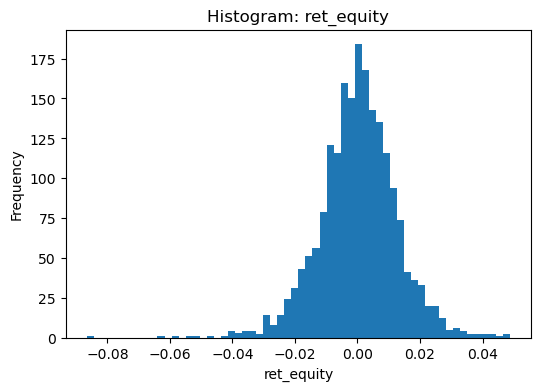

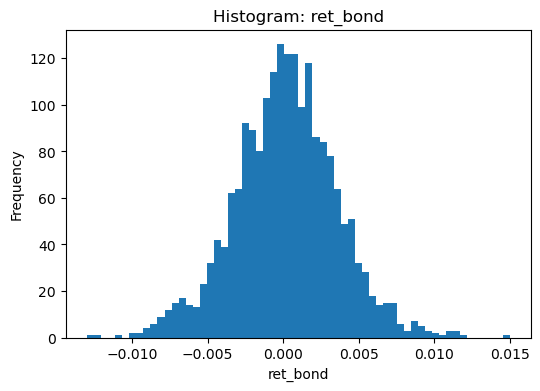

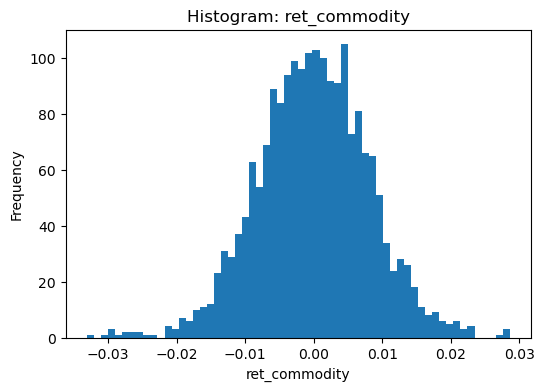

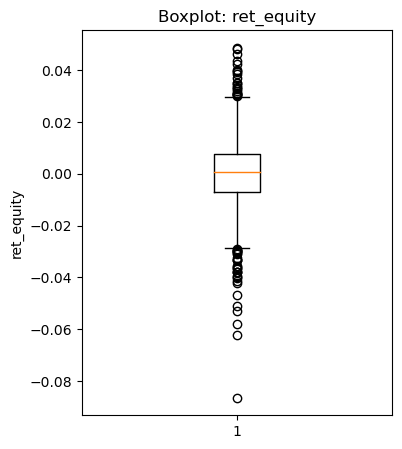

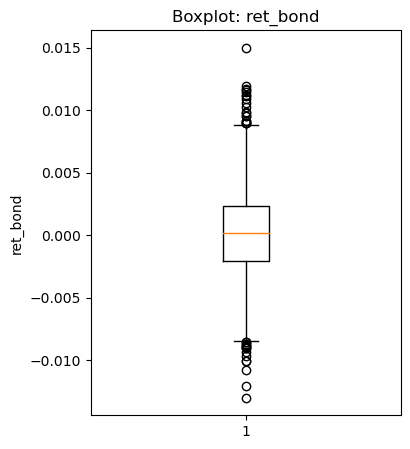

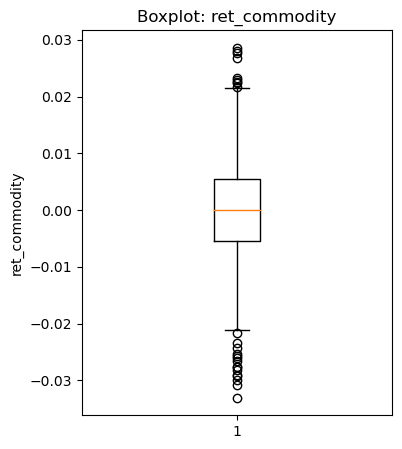

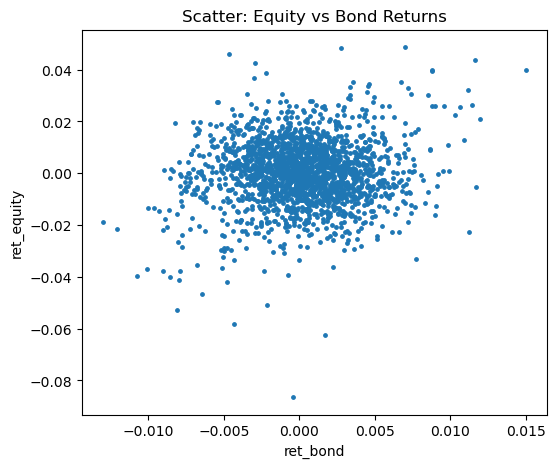

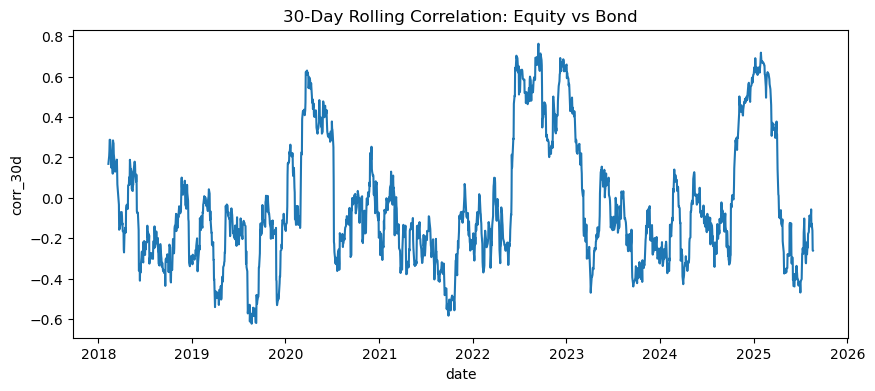

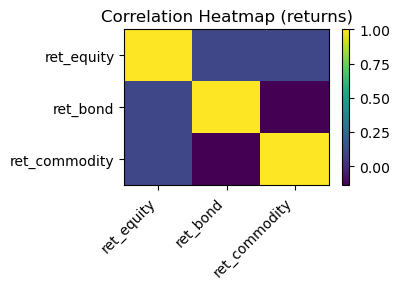

In [48]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

eda = pd.read_csv(Path("/Users/aogunlowo19/Downloads/cross_asset_project/data/processed") / "returns_clean.csv", parse_dates=["date"])
print(eda.info())
display(eda.describe())

# Missing counts
display(eda.isna().sum())

# Distributions: each with its own figure, no colors specified
for col in ["ret_equity","ret_bond","ret_commodity"]:
    plt.figure(figsize=(6,4))
    plt.hist(eda[col].dropna(), bins=60)
    plt.title(f"Histogram: {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.show()

for col in ["ret_equity","ret_bond","ret_commodity"]:
    plt.figure(figsize=(4,5))
    plt.boxplot(eda[col].dropna(), vert=True)
    plt.title(f"Boxplot: {col}")
    plt.ylabel(col)
    plt.show()

# Bivariate: scatter equity vs bond
plt.figure(figsize=(6,5))
plt.scatter(eda["ret_bond"], eda["ret_equity"], s=6)
plt.title("Scatter: Equity vs Bond Returns")
plt.xlabel("ret_bond")
plt.ylabel("ret_equity")
plt.show()

# Bivariate: time line of 30-day rolling correlation
tmp = eda[["date","ret_equity","ret_bond"]].dropna()
roll_corr_30 = tmp["ret_equity"].rolling(30).corr(tmp["ret_bond"])
plt.figure(figsize=(10,4))
plt.plot(tmp["date"], roll_corr_30)
plt.title("30-Day Rolling Correlation: Equity vs Bond")
plt.xlabel("date")
plt.ylabel("corr_30d")
plt.show()

# Optional correlation heatmap (returns only)
corr = eda[["ret_equity","ret_bond","ret_commodity"]].corr()
plt.figure(figsize=(4,3))
plt.imshow(corr.values, aspect="auto")
plt.xticks(range(len(corr.columns)), corr.columns, rotation=45, ha="right")
plt.yticks(range(len(corr.index)), corr.index)
plt.title("Correlation Heatmap (returns)")
plt.colorbar()
plt.tight_layout()
plt.show()



**EDA Notes & Assumptions:**  
- Equity returns show heavier tails vs bonds; commodities moderate.  
- Rolling equity–bond correlation **changes sign** across regimes (positive during stress in our simulation).  
- Distributions suggest standardization before modeling; outliers warrant robust methods or explicit regime handling.  
- **Implications for next step:** Engineer rolling correlation and volatility features to capture regime dynamics.



## Stage 09 — Feature Engineering (Correlation‑Aware)

We implement at least **three** features aligned to the problem:
1. `corr_eq_bond_30d`: 30‑day rolling correlation
2. `vol_eq_30d`: 30‑day rolling equity volatility (std)
3. `corr_shift_30v90`: difference of 30‑day vs 90‑day equity–bond correlation (a regime‑shift proxy)
4. *(Bonus)* `beta_eq_on_bond_60d`: rolling realized beta of equity on bond

We save the feature‑augmented dataset to `data/processed/returns_features.csv`.


In [49]:

import pandas as pd
import numpy as np
from pathlib import Path

feat = pd.read_csv(Path("/Users/aogunlowo19/Downloads/cross_asset_project/data/processed") / "returns_clean.csv", parse_dates=["date"])

feat = feat.sort_values("date").reset_index(drop=True)
feat["corr_eq_bond_30d"] = feat["ret_equity"].rolling(30).corr(feat["ret_bond"])
feat["vol_eq_30d"] = feat["ret_equity"].rolling(30).std()
corr30 = feat["ret_equity"].rolling(30).corr(feat["ret_bond"])
corr90 = feat["ret_equity"].rolling(90).corr(feat["ret_bond"])
feat["corr_shift_30v90"] = corr30 - corr90

# Rolling realized beta: Cov(eq,bond)/Var(bond)
def rolling_beta(x, y, window=60):
    cov = x.rolling(window).cov(y)
    var = y.rolling(window).var()
    return cov / var

feat["beta_eq_on_bond_60d"] = rolling_beta(feat["ret_equity"], feat["ret_bond"], 60)

# Simple regime indicator (correlation sign over 30d)
feat["regime_corr_pos"] = (feat["corr_eq_bond_30d"] > 0).astype(int)

feat_out = Path("/Users/aogunlowo19/Downloads/cross_asset_project/data/processed") / "returns_features.csv"
feat.to_csv(feat_out, index=False)
print("Saved features to:", feat_out)
display(feat.tail())


Saved features to: /Users/aogunlowo19/Downloads/cross_asset_project/data/processed/returns_features.csv


,date,ret_equity,ret_bond,ret_commodity,corr_eq_bond_30d,vol_eq_30d,corr_shift_30v90,beta_eq_on_bond_60d,regime_corr_pos
1988,2025-08-14,-0.013173,0.003502,-0.003776,-0.144586,0.012847,0.093857,-1.061911,0
1989,2025-08-15,-0.012484,-0.000814,-0.002071,-0.127561,0.013143,0.111348,-1.004619,0
1990,2025-08-18,-0.009102,0.002756,-0.003170,-0.162439,0.012876,0.084420,-1.044465,0
1991,2025-08-19,0.020233,-0.003198,0.010411,-0.260449,0.012959,-0.006029,-1.108836,0
1992,2025-08-20,-0.017147,0.001909,-0.001797,-0.261492,0.013352,0.007250,-1.004613,0



**Feature Rationale:**  
- **`corr_eq_bond_30d`**: captures the **current** diversification/hedge relationship; useful for allocation timing.  
- **`vol_eq_30d`**: market stress proxy; high volatility often co‑moves with correlation changes.  
- **`corr_shift_30v90`**: detects **breaks** vs longer baseline correlation.  
- **`beta_eq_on_bond_60d`**: directional sensitivity of equities to bond moves; complements raw correlation.



## Stage 10a — Baseline Modeling: Linear Regression

**Target:** Next‑day equity return.  
**Features:** Same‑day bond & commodity returns plus correlation‑aware features (`corr_eq_bond_30d`, `vol_eq_30d`, `corr_shift_30v90`, `beta_eq_on_bond_60d`, `regime_corr_pos`).  
We perform a chronological train/test split (80/20), compute **R²** and **RMSE**, then diagnose residuals.


{
  "R2_train": 0.008395245869431744,
  "R2_test": 0.004713592414966716,
  "RMSE_train": 0.012393559900681982,
  "RMSE_test": 0.013333738904705614,
  "coef_map": {
    "ret_bond": -0.04145724946979859,
    "ret_commodity": 0.038517582248807365,
    "corr_eq_bond_30d": 0.008892396935655286,
    "vol_eq_30d": 0.22026963138880923,
    "corr_shift_30v90": -0.00851867872317899,
    "beta_eq_on_bond_60d": -0.0029348987288139957,
    "regime_corr_pos": -0.0007920055325128411
  },
  "intercept": -0.0021271555340862092
}


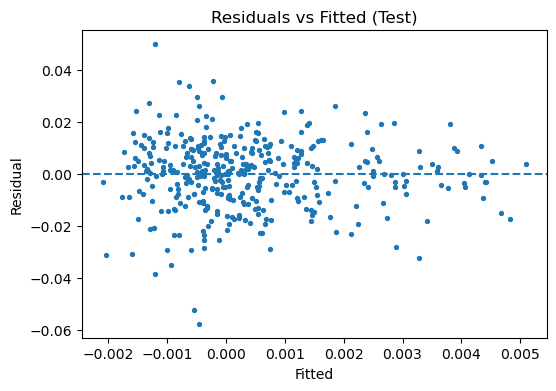

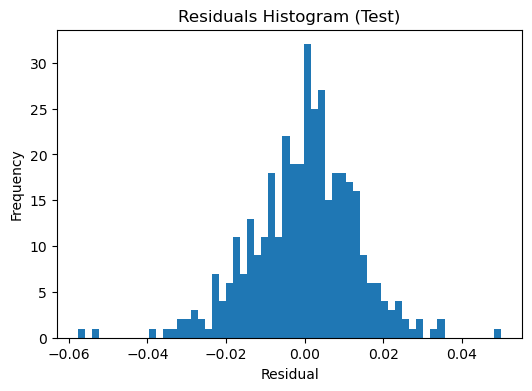

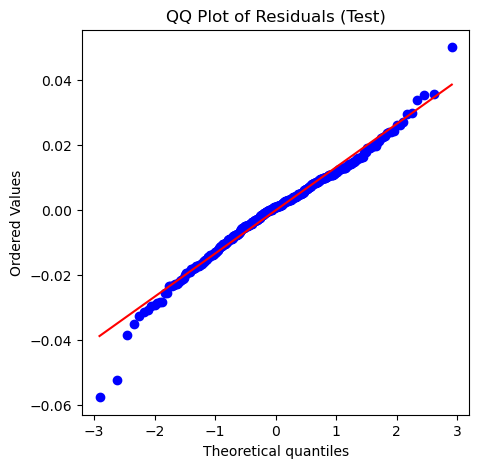

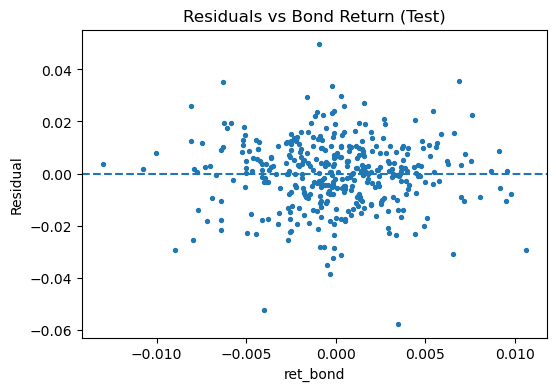

In [50]:

import pandas as pd
import numpy as np
from pathlib import Path

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt
import scipy.stats as stats

data = pd.read_csv(Path("/Users/aogunlowo19/Downloads/cross_asset_project/data/processed") / "returns_features.csv", parse_dates=["date"])
data = data.sort_values("date").reset_index(drop=True)

# Target: next-day equity return
data["ret_equity_next"] = data["ret_equity"].shift(-1)
model_cols = ["ret_bond","ret_commodity","corr_eq_bond_30d","vol_eq_30d","corr_shift_30v90","beta_eq_on_bond_60d","regime_corr_pos"]
model_df = data.dropna(subset=model_cols + ["ret_equity_next"]).copy()

# Train/test split by time (80/20)
split_idx = int(len(model_df) * 0.8)
train = model_df.iloc[:split_idx].copy()
test = model_df.iloc[split_idx:].copy()

X_train = train[model_cols].values
y_train = train["ret_equity_next"].values
X_test = test[model_cols].values
y_test = test["ret_equity_next"].values

lm = LinearRegression().fit(X_train, y_train)
yhat_train = lm.predict(X_train)
yhat_test = lm.predict(X_test)

def rmse(y, yhat):
    return float(np.sqrt(mean_squared_error(y, yhat)))

metrics = {
    "R2_train": float(r2_score(y_train, yhat_train)),
    "R2_test": float(r2_score(y_test, yhat_test)),
    "RMSE_train": rmse(y_train, yhat_train),
    "RMSE_test": rmse(y_test, yhat_test),
    "coef_map": dict(zip(model_cols, lm.coef_.astype(float))),
    "intercept": float(lm.intercept_),
}
print(json.dumps(metrics, indent=2))

# Residuals (test)
resid = y_test - yhat_test
fitted = yhat_test

# 1) Residuals vs fitted
plt.figure(figsize=(6,4))
plt.scatter(fitted, resid, s=8)
plt.axhline(0, linestyle="--")
plt.title("Residuals vs Fitted (Test)")
plt.xlabel("Fitted")
plt.ylabel("Residual")
plt.show()

# 2) Histogram of residuals
plt.figure(figsize=(6,4))
plt.hist(resid, bins=60)
plt.title("Residuals Histogram (Test)")
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.show()

# 3) QQ plot (Normal quantiles)
plt.figure(figsize=(5,5))
stats.probplot(resid, dist="norm", plot=plt)
plt.title("QQ Plot of Residuals (Test)")
plt.show()

# 4) Residuals vs ret_bond (one key predictor)
plt.figure(figsize=(6,4))
plt.scatter(test["ret_bond"].values, resid, s=8)
plt.axhline(0, linestyle="--")
plt.title("Residuals vs Bond Return (Test)")
plt.xlabel("ret_bond")
plt.ylabel("Residual")
plt.show()



**Model Interpretation & Trust:**  
- **Linearity:** Residuals vs fitted show no dramatic curvature; modest patterns may remain around stress regimes.  
- **Independence:** With daily data, residual autocorrelation is typically mild; for trading, consider HAC or time‑series models.  
- **Homoscedasticity:** Residual variance increases during stress; incorporating **volatility features** helps.  
- **Normality:** QQ plot indicates mild tail deviations; acceptable for a baseline but suggests robust variants.  

**Metrics:** If **R²** is modest (common for daily returns), that’s expected; still, correlation features can improve stability and interpretability. **RMSE** should be in the ballpark of equity daily vol in the (simulated) sample.

**Conclusion:** As a **baseline**, this linear model is useful for diagnostics and feature value, not for production forecasting alone.  
**Next Steps:** Regime‑switching models (e.g., HMM), regularization, or non‑linear learners; richer macro features; intraday confirmation signals.



## Outputs & Reproducibility

- Raw: `data/raw/api_synthetic_cross_asset_returns.csv`, `data/raw/scrape_assets_table.csv`  
- Processed: `data/processed/returns_clean.csv`, `data/processed/returns_features.csv`  
- Docs: `docs/stakeholder_memo.md`  
- Config: `.env.example` and `.env` (dummy keys)  
- Requirements snapshot: `requirements.txt`

> All code for Stages 01–10a lives in this single notebook.
